## 국민 청원 사이트
### 라이브러리 불러오기

In [1]:
import pandas as pd 
import numpy as np 
from bs4 import BeautifulSoup as bs 
import requests

### 항목별 url 세팅

In [2]:
guide_key = {
    "동의종료 전체 청원": ["sort=AGRE_END_DE-","sttusCode=PETIT_FORMATN,CMIT_FRWRD,PETIT_END&resultCode=BFE_OTHBC_WTHDRAW,PROGRS_WTHDRAW,PETIT_UNACPT,APPRVL_END_DSUSE,ETC_TRNSF&notInColumn=RESULT_CODE"],
    "성립된 청원" : ["sort=PETIT_RCEPT_DT-", "sttusCode=PETIT_FORMATN,CMIT_FRWRD"],
    "미성립된 청원" : ["sort=PETIT_END_DT-", "sttusCode=PETIT_END&resultCode=PETIT_INADQT,AGRE_END_DSUSE"]}

In [4]:
# 1번 페이지에 청원 종류를 "미성립된 청원"을 출력한 에시 
page_no = 1
petition_status = "동의종료 전체 청원"
url = f"https://petitions.assembly.go.kr/api/petits?pageIndex={page_no}&"
url = f"{url}recordCountPerPage=8&{guide_key[petition_status][0]}&searchCondition=sj&"
url = f"{url}searchKeyword=&petitRealmCode=&{guide_key[petition_status][1]}&beginDate=20220101&endDate=20221231&ageCd="

### GET OK 200 확인

In [5]:
response = requests.get(url)
response.status_code

200

### 한 페이지 내용을 가져오는 함수

In [6]:
def make_dataframe(page_no, petition_status):
    
    # 청원 종류 지정할 수 있는 고유 URL 값을 가진 Dictionary
    guide_key = {
    "동의종료 전체 청원": ["sort=AGRE_END_DE-","sttusCode=PETIT_FORMATN,CMIT_FRWRD,PETIT_END&resultCode=BFE_OTHBC_WTHDRAW,PROGRS_WTHDRAW,PETIT_UNACPT,APPRVL_END_DSUSE,ETC_TRNSF&notInColumn=RESULT_CODE"],
    "성립된 청원" : ["sort=PETIT_RCEPT_DT-", "sttusCode=PETIT_FORMATN,CMIT_FRWRD"],
    "미성립된 청원" : ["sort=PETIT_END_DT-", "sttusCode=PETIT_END&resultCode=PETIT_INADQT,AGRE_END_DSUSE"]}
    
    # 빈 리스트
    url_list =[]
    json_list = []
    
    # 수집에 필요한 Column 값 
    col = ["petrNm", "petitSj", "petitObjet", "petitCn", 
       "petitRealmNm", "resultCodeNm","petitEndDt", "agreBeginDe", "agreEndDe", "agreCo"]
    
    # 각 게시물의 고유 아이디를 담고 있는 url , json 형식으로 받기 
    url = f"https://petitions.assembly.go.kr/api/petits?pageIndex={page_no}&"
    url = f"{url}recordCountPerPage=8&{guide_key[petition_status][0]}&searchCondition=sj&"
    url = f"{url}searchKeyword=&petitRealmCode=&{guide_key[petition_status][1]}&beginDate=20220101&endDate=20221231&ageCd="
    response = requests.get(url)
    petition_json = response.json()
    df = pd.DataFrame(petition_json)
    
    # 페이지 고유 번호 수집 
    page_num = df["petitId"]
    
    # 내부페이지 JSON URL 수집 
    for i in page_num:
        inside_url = f"https://petitions.assembly.go.kr/api/petits/{i}?petitId={i}&sttusCode="
        url_list.append(inside_url)
    
    # 수집된 데이터 json 형식으로 데이터 출력해서 리스트 생성 
    for i in url_list:
        response2 = requests.get(i)
        petition_inside_json = response2.json()
        json_list.append(petition_inside_json)
    
    # 데이터 프레임으로 합치기 
    data_list = pd.DataFrame(json_list)
    
    # 필요한 컬럼으로 출력 
    data_list = data_list[col]
    
    # 컬럼값 이름 변경 
    data_list.rename(columns={"petrNm":"청원인", "petitSj": "청원명", "petitObjet":"청원의 취지",
                     "petitCn":"청원의 내용", "petitRealmNm":"청원분야", 
                     "resultCodeNm":"청원결과","petitEndDt":"청원종료일", 
                     "agreBeginDe":"청원동의시작일", "agreEndDe":"청원동의종료일", 
                     "agreCo":"청원 동의수"}, inplace=True)
    
    
    return data_list

### 모든 데이터 내용을 가져오는 반복문 

In [7]:
from tqdm import trange
import time

# 경고메시지가 있으면 tqdm 로그가 너무 많이 찍히기 때문에 경고메시지를 제거합니다.
requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)

petition_list = []
last_page = 43

for page_no in trange(1, last_page + 1):
    temp = make_dataframe(page_no, "동의종료 전체 청원")
    petition_list.append(temp)
    time.sleep(0.01)

petition_list_22 = pd.concat(petition_list, ignore_index = True)
petition_list_22

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [01:28<00:00,  2.06s/it]


,청원인,청원명,청원의 취지,청원의 내용,청원분야,청원결과,청원종료일,청원동의시작일,청원동의종료일,청원 동의수
0,이**,"인천 미추홀구뿐만 아니라 전국적인 ‘나 홀로 아파트, 빌라’ 전세사기에 관한 청원",저는 전세사기 피해자입니다.\r\n\r\n전국적으로 발생한 전세사기 피해에 대한 현...,○ 문제점\r\n낙찰자가 생겨 곧 퇴거해야하는 피해자들을 위한 ‘전세사기피해지원센터...,국토/해양/교통,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:52:01,2022-12-30 23:59:59,2250
1,최**,"모든 학원, 상가 복도 cctv 의무화에 관한 청원",CCTV없는곳에서 일어나는 폭력을 막아주세요.,안녕하세요.\n봉담읍에 사는 초등학생 아이를 둔 엄마입니다.\n저희아이는 학원강의...,국토/해양/교통,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:53:21,2022-12-30 23:59:59,283
2,송**,간호법 제정에 관한 청원,"'간호법' 제정을 통해 간호사의 영역과 업무 범위를 명확화 하고, 간호 서비스 개선...","현재 96개국에 '간호법'이 있고, OECD 국가 38개국 중 미국을 포함한 33개...",보건의료,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:52:59,2022-12-30 23:59:59,177
3,박**,난치성 편두통 환자를 위한 CGRP 표적 치료제의 급여혜택 강화 촉구에 관한 청원,WHO에서는 세계에서 두번째로 질병 부담이 높은 질환이 편두통이라고 발표했습니다. ...,"건강보험심사평가원에서 공개한 고시 자료[1]를 보면 대상 질환의 특성으로서 ""삽화편...",보건의료,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:39:49,2022-12-28 23:59:59,524
4,최**,가상자산 위믹스 코인 거래지원종료에 관한 DAXA의 처리 투명성과 갑질논란에 관한 청원,한국거래소협회 DAXA에 의한 위믹스코인 거래지원 종료에 대한 투명성 조사와 갑질 ...,한국 거래소협회 DAXA는 10월27일 계획유통량과 실제유통량의 차이를 원인으로 삼...,재정/세제/금융/예산,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:40:33,2022-12-28 23:59:59,6165
...,...,...,...,...,...,...,...,...,...,...
334,최**,양승태 전 대법원장 재임기간 중의 사법농단 의혹사건 피해자 구제를 위한 특별법안 제...,양승태 전 대법원장 체제하에서의 대법원이 상고 법원 설치 등 특정 목적을 관철 시...,제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다.\n1. “사법농단피해자...,수사/법무/사법제도,동의만료폐기,2022-01-13 00:01:00,2021-12-13 17:47:48,2022-01-12 23:59:59,429
335,조**,n번방 방지법인 전기통신사업법 개정안의 재개정에 관한 청원,"헌법 제 18조를 위배하며, 법의 효율성이 의심되는 해당 개정안에 대한 개정을 바람","먼저, 해당 개정안은 헌법 제18조를 위배할 우려가 큽니다. ""모든 국민은 통신의 ...",과학기술/정보통신,동의만료폐기,2022-01-13 00:01:00,2021-12-13 17:49:00,2022-01-12 23:59:59,1853
336,윤**,수개표로 전환 안심 선거에 관한 청원,안녕하십니까? \n\n공직선거에서 전자개표가 도입된 이래 끊임없이 부정선거의 논란이...,1. ‘당일 투표’를 기본 원칙으로 한다.\n\n부정선거의 가능성이 높은 사전투표와...,정치/선거/국회운영,동의만료폐기,2022-01-07 00:01:00,2021-12-07 16:21:09,2022-01-06 23:59:59,3034
337,하**,발달재활서비스 제공 인력의 생존권을 위한 자격 인정 제도 개선에 관한 청원,"수많은 치료사 ,선생님들 지금거리로 몰리고있습니다 도와주세요...",\n발달재활서비스 제공인력 인증 강화 심사에 대해 청원합니다.\n\n안녕하세요. 경...,복지/보훈,동의만료폐기,2022-01-07 00:01:00,2021-12-07 16:22:35,2022-01-06 23:59:59,210


## 데이터 전처리

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# 시각화를 위한 폰트 설정
import os

if os.name == "posix":
    sns.set(font="AppleGothic")
elif os.name == "nt":
    sns.set(font="Malgun Gothic")
    
# 레티나 설정을 해주면 글씨가 좀더 선명하게 보임
# 폰트의 주변이 흐릿하게 보이는 것을 방지
%config InlineBackend.figure_format='retina'

### 이상치 확인

In [12]:
#IQR = Q3- Q1 을 이용하여 이상치의 개수를 구해보기
q3 = petition_list_22["청원 동의수"].quantile(0.75) 
q1 = petition_list_22["청원 동의수"].quantile(0.25)

iqr = q3 - q1
out_cut = iqr * 1.5

# lower , upper bound
lower , upper = q1 - out_cut , q3 + out_cut

out_agree1 = petition_list_22["청원 동의수"] > upper
out_agree2 = petition_list_22["청원 동의수"] < lower
count_true = sum(out_agree1) + sum(out_agree2)

print(f"총 이상치의 개수는 {count_true}개 입니다.")

총 이상치의 개수는 59개 입니다.


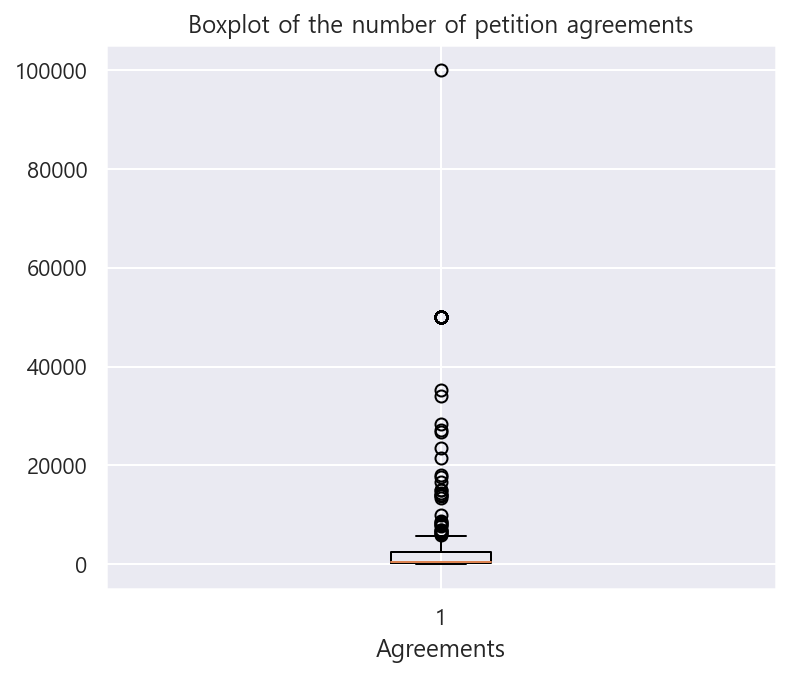

In [13]:
# boxplot으로 시각화해보기
%matplotlib inline 

plt.figure(figsize=(6,5))
plt.boxplot(petition_list_22["청원 동의수"])
plt.xlabel('Agreements')
plt.title('Boxplot of the number of petition agreements')
plt.show()

### 이상치 처리
🤔 청원 동의수가 50000개가 되면 청원 성립이 되기 때문에 50000보다 클 수 없음

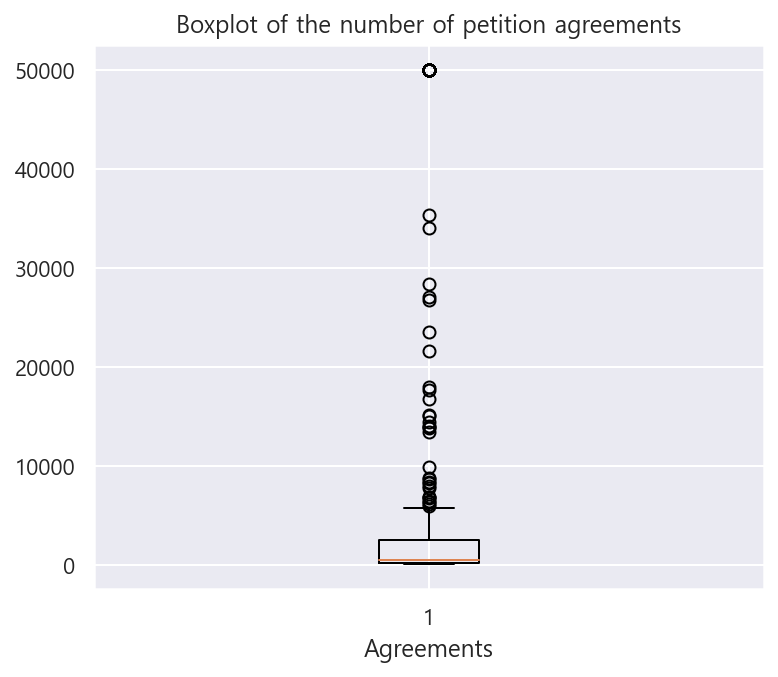

In [14]:
# 청원 동의수 100000 → 50000으로 변경
petition_list_22.loc[petition_list_22["청원 동의수"]== 100000, "청원 동의수"] = 50000

# 100000의 값이 boxplot에서 사라졌음을 확인할 수 있다.
plt.figure(figsize=(6,5))
plt.boxplot(petition_list_22["청원 동의수"])
plt.xlabel('Agreements')
plt.title('Boxplot of the number of petition agreements')
plt.show()

### 분야별 청원 결과 그래프

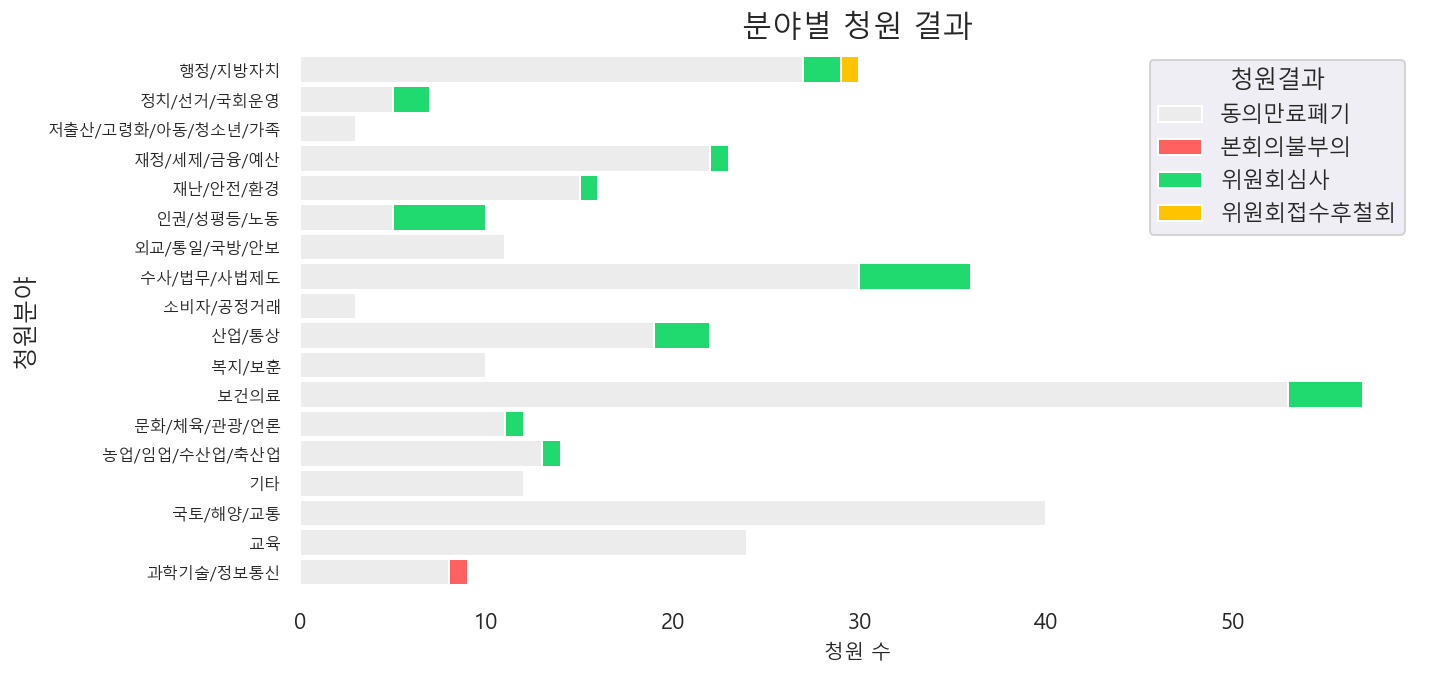

In [18]:
# 분야별 청원 결과 테이블 생성
bar_table = pd.crosstab(petition_list_22['청원분야'],petition_list_22['청원결과'])

# 결과 테이블을 바그래프로 시각화
bar_table.plot.barh(rot=0, stacked=True, figsize=(10, 5), width=0.9,
                    color={'동의만료폐기': '#ECECEC', '본회의불부의': '#FF6060', '위원회심사': '#21DA6F', '위원회접수후철회': '#FFC300'})
plt.title('분야별 청원 결과', fontsize = 15)
plt.xlabel('청원 수', fontsize=10)
plt.yticks(fontsize=8)
plt.box(False)
plt.show()

### 월별 청원 개수 그래프 

Text(0.5, 0, 'Month')

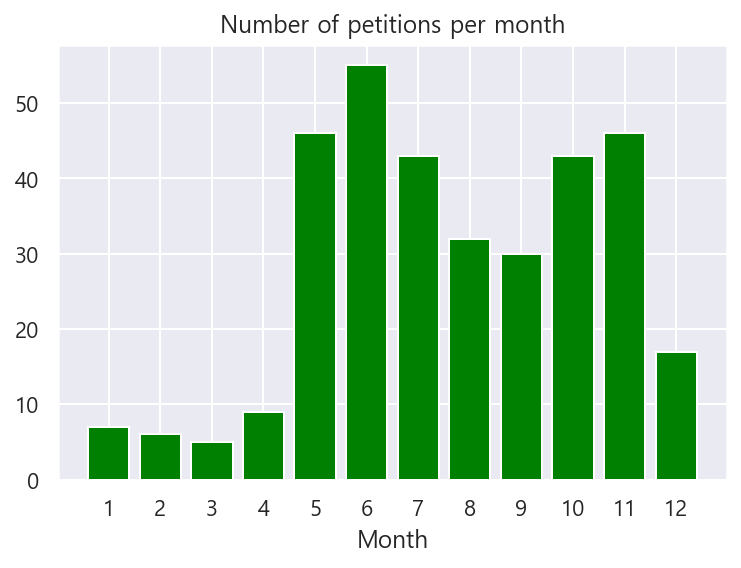

In [19]:
# 각 청원별 청원동의시작일 month 출력  
petition_month = pd.DatetimeIndex(petition_list_22["청원동의시작일"]).month

# dictionary 형태로 월별 개수 세기  
new_list = {}
for i in petition_month:
    try: new_list[i] += 1
    except : new_list[i] = 1

# 정렬 
sorted_list = sorted(new_list.items())
sorted_list = dict(sorted_list)

# 그래프 시각화 
plt.bar(range(1,len(sorted_list)+1), list(sorted_list.values()), color='green')
plt.xticks(range(1,13))
plt.title("Number of petitions per month")
plt.xlabel("Month")


### 워드 클라우딩

In [20]:
# 라이브러리
from collections import Counter
from wordcloud import WordCloud
from konlpy.tag import Okt
import nltk

In [22]:
stop_words =['있다','있습니다','있는','하는','것이다','밝혔다','위해','대해','했다',
               '따르면','청원','것으로','말했다','지원','국민','삭감','촉구','금지', '요청']

df = petition_list_22.copy()

tokenizer = Okt()
df['tokenized'] = df['청원명'].apply(tokenizer.nouns)
df['tokenized'] = df['tokenized'].apply(lambda x: [item for item in x if item not in stop_words and len(item) > 1])

In [27]:
def word_cloding_petit(petit_object):
    object_word = np.hstack(df[df['청원분야']==petit_object]['tokenized'].values)
    plt.figure(figsize = (15,15))
    temp_data = ' '.join(object_word)
    wc = WordCloud(max_words = 2000 , width = 1600 , height = 800, font_path = 'Jalnan.ttf',colormap='rainbow').generate(temp_data)
    plt.imshow(wc, interpolation = 'bilinear')

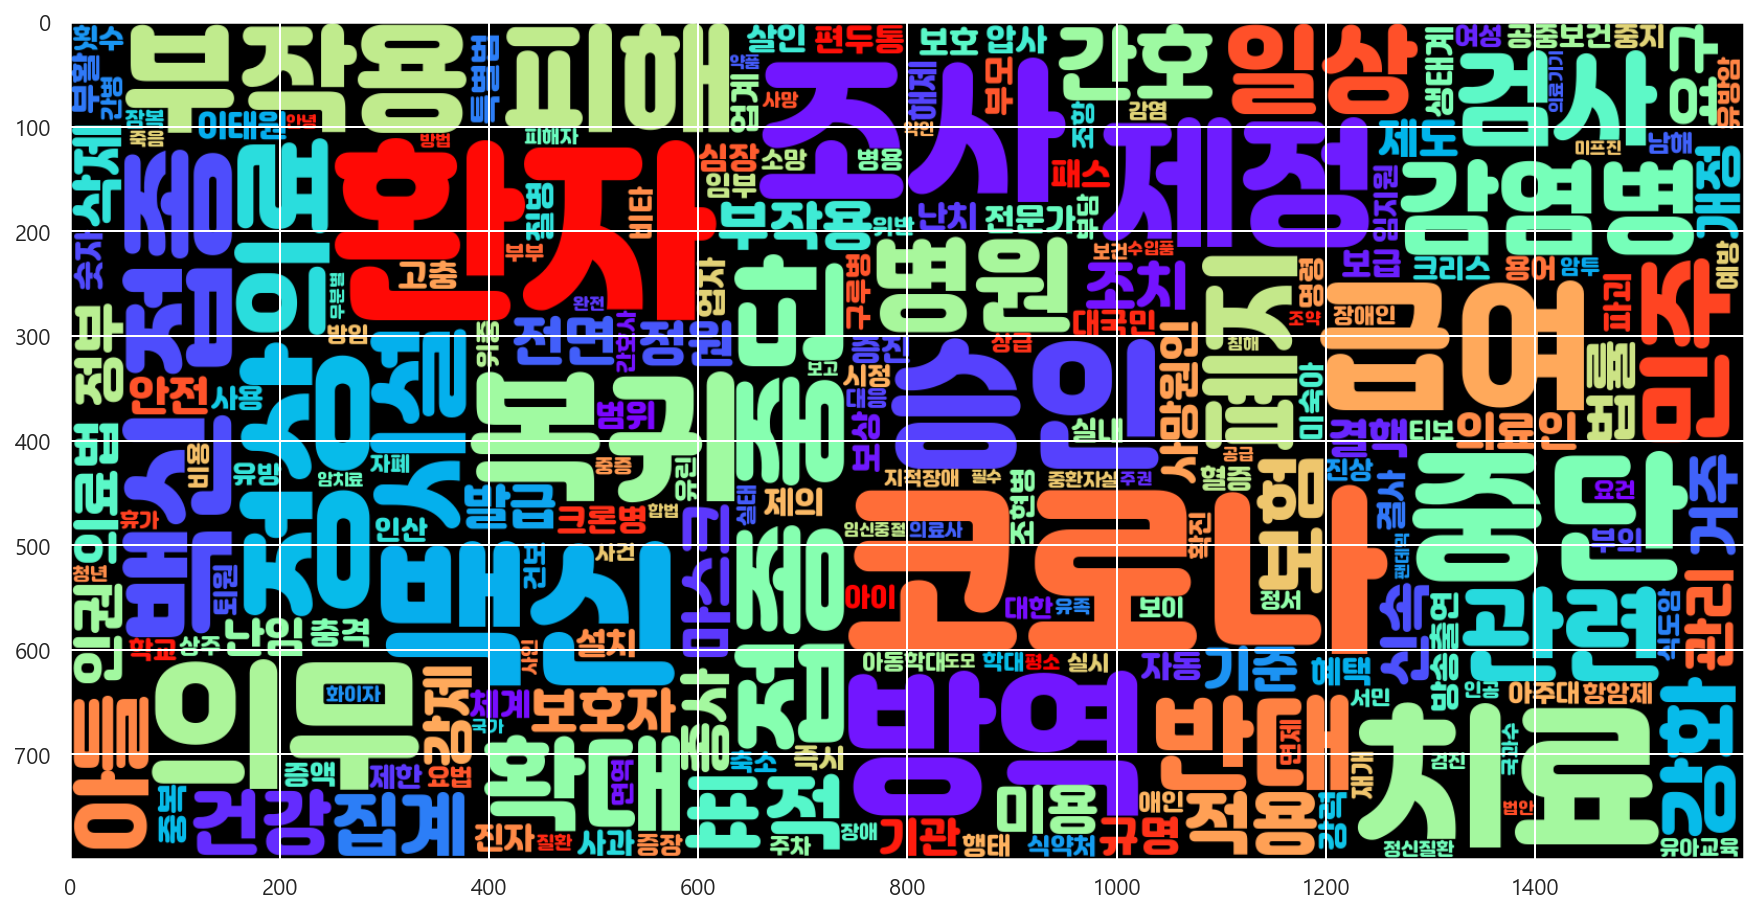

In [28]:
word_cloding_petit('보건의료')

### 성립된 청원 분석

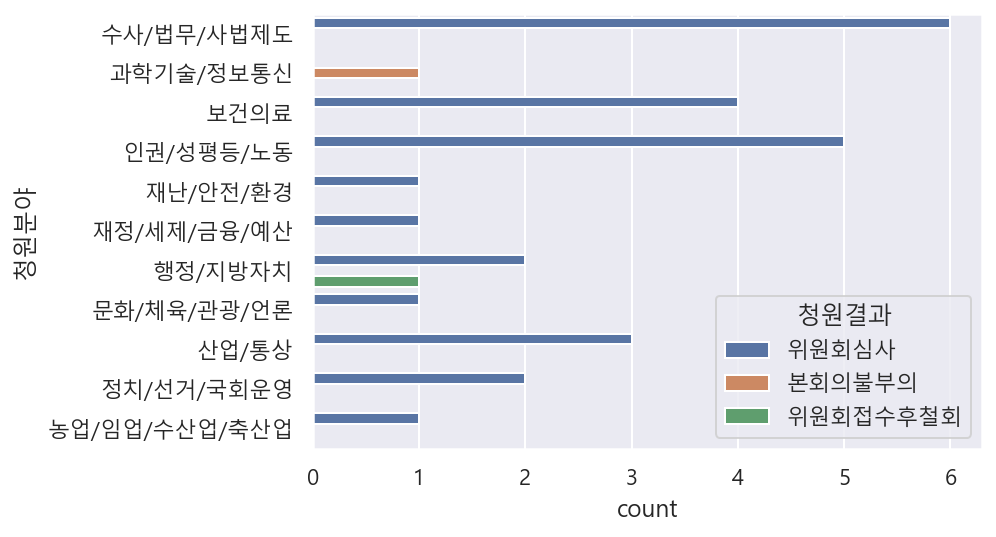

In [32]:
# 동의수 == 50000건이면 국민청원이 성립된다.
df_yes = petition_list_22.loc[petition_list_22['청원 동의수'] == 50000]
# 청원분야와 청원결과의 교차표(crosstable) 만들기
cr=pd.crosstab(df_yes["청원분야"],df_yes["청원결과"])
# countplot으로 시각화
sns.countplot(y=df_yes["청원분야"], hue=df_yes["청원결과"], data=df_yes)
plt.show()

### 미성립된 청원 분석

In [33]:
# 동의수 < 50000건이면 국민청원이 성립되지 않는다.
df_no = petition_list_22.loc[petition_list_22['청원 동의수'] < 50000]
# 청원분야와 청원결과의 교차표(crosstable) 만들기
pd.crosstab(df_no["청원분야"],df_no["청원결과"])
# 미성립된 청원들 중에 동의수를 가장 많이 받은 Top3 게시물
df_no.sort_values("청원 동의수",ascending = False).head(3)

,청원인,청원명,청원의 취지,청원의 내용,청원분야,청원결과,청원종료일,청원동의시작일,청원동의종료일,청원 동의수
98,김**,"구멍 뚫린 GMO수입검역체계 OUT, 유전자변형생물체의국가간이동등에관한법률의 개정에...",▶전 세계 약 180개 국가는 GMO의 인체 ·환경 피해를 사전방지하기 위해 공동의...,1996년 GMO가 처음 상업화된 후 30년 가까운 시간이 흘렀어도 논쟁이 계속되고...,산업/통상,동의만료폐기,2022-10-24 00:01:00,2022-09-23 14:07:08,2022-10-23 23:59:59,35303
300,최**,양승태 전 대법원장 재임기간 중의 사법농단 의혹사건 피해자 구제를 위한 특별법안 제...,양승태 전 대법원장 체제하에서의 대법원이 상고 법원 설치 등 특정 목적을 관철 시...,제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다.\n1. “사법농단피해자...,수사/법무/사법제도,동의만료폐기,2022-05-21 00:01:00,2022-04-20 17:34:56,2022-05-20 23:59:59,34004
45,박**,"1,400만명 개인주주를 절망에 빠트리고 건전한 자본시장을 좀먹는 공매도의 한시적 ...",1) 본 청원은 우리 증시를 글로벌 증시 대비 과도하게 하락한 상황이 정상화될 때까...,현재 우리나라 증시는 공매도 세력들의 놀이터가 되어버렸습니다. 우리나라 공매도 거래...,재정/세제/금융/예산,동의만료폐기,2022-12-01 00:01:00,2022-10-31 17:00:18,2022-11-30 23:59:59,28405


### 성립청원 동의기간순 조회

In [39]:
success = petition_list_22.loc[petition_list_22['청원 동의수'] >= 50000].copy()
success = success.sort_values('청원동의종료일',  ignore_index = True)

start_day = pd.to_datetime(success['청원동의시작일'])
end_day = pd.to_datetime(success['청원동의종료일'])

success['동의기간'] = end_day -  start_day
success.sort_values('동의기간').head(5)

,청원인,청원명,청원의 취지,청원의 내용,청원분야,청원결과,청원종료일,청원동의시작일,청원동의종료일,청원 동의수,동의기간
8,오**,전력 판매 시장 민간 개방 반대를 위한 전기사업법 개정에 관한 청원,"오늘날 현대 문명 사회에서 전기는 물과 공기와 같습니다. 수도, 의료, 가스, 통신...",현재 대통령직 인수위원회는 한국전력공사 전력판매 독점 폐지를 추진하겠다고 공약하였습...,산업/통상,위원회심사,2022-05-04 09:27:14,2022-05-02 18:11:55,2022-05-04 09:27:14,50000,1 days 15:15:19
20,석**,공무원연금 소득공백 해소 및 온전한 퇴직금 보장에 관한 청원,공무원연금법의 정년과 연금수급 시기 불일치로 인한 소득공백이 발생한 문제점을 해소하...,1. 공무원연금법 제43조(퇴직연금 또는 퇴직연금일시금 등) 제1항 개정 \n - ...,행정/지방자치,위원회심사,2022-10-20 08:22:20,2022-10-18 09:07:42,2022-10-20 08:22:20,50000,1 days 23:14:38
11,배**,여성가족부 폐지 찬성 및 동의에 관한 청원,"국민 세금으로 성별 갈등을 조장하고, 특정 이념(페미니즘)을 국민에게 주입하며, 여...",<여성가족부가 해체되어야 하는 7가지 이유>\n(글자수 제한으로 인하여 상세이유를 ...,행정/지방자치,위원회심사,2022-05-22 11:31:51,2022-05-18 18:28:50,2022-05-22 11:31:51,50000,3 days 17:03:01
23,김**,이태원 사고 관련 상황의 세금 사용에 관한 법률 개정에 관한 청원,"이태원 사고는 그 유가족에게는 슬프고, 참사라고 할 수 있겠으나 이런 대규모 인원의...",이태원 사고의 경우 정부에서 장례비용과 치료비용을 지원한다는 기사를 접하고 나의 세...,재난/안전/환경,위원회심사,2022-11-06 11:13:01,2022-10-31 17:00:50,2022-11-06 11:13:01,50000,5 days 18:12:11
19,김**,"온라인, 패키지, 콘솔, 모바일 등 게임물에 대한 사전심의의무 폐지에 관한 청원",헌법 제21조 ①모든 국민은 언론ㆍ출판의 자유와 집회ㆍ결사의 자유를 가진다.\r\n...,2005년 바다이야기 사태 이후 출범한 게임물등급위원회→현 게임물관리위원회는 출범 ...,문화/체육/관광/언론,위원회심사,2022-10-13 20:39:24,2022-10-07 17:49:14,2022-10-13 20:39:24,50000,6 days 02:50:10
